In [4]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as PhysLoss
import network_utils as nuts

torch.manual_seed(28)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This second NN will incorporate morphological information. However, morphological descriptors will be averaged per sample, similar to how device metrics are an average of performance across the active layer

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. This will similarly only include good devices

- DataFrame containing device-averaged morphology descriptors

### Outputs:
- Tensor of predicted performance for given processing conditions

In [16]:
#Take in data as a dataframe for easy preprocessing
total_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/OPV_total_df.xlsx')
print (total_df.shape)
total_df.head()

(36, 60)


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,p1_fraction,p2_fraction,p3_fraction,p1_area_avg,p1_area_stdev,...,p3_Ecc_avg,p3_Ecc_stdev,p3_Orient_avg,p3_Orient_stdev,p3_Perim_avg,p3_Perim_stdev,PCE,VocL,Jsc,FF
0,0,15,100,4,2,0.377864,0.397964,0.224172,138.756250,515.165733,...,0.806425,0.141707,-0.028958,1.145651,27.843437,33.295642,2.311387,0.577792,6.963861,57.44484
1,1,15,100,4,4,0.350601,0.368873,0.280526,78.978947,180.249005,...,0.817408,0.147199,0.053783,1.171795,42.334954,73.576430,1.763230,0.522596,7.047848,47.87256
2,2,15,100,4,7,0.290203,0.329655,0.380142,122.638743,246.651556,...,0.840800,0.129785,-0.158463,1.160457,42.913004,88.566792,2.394418,0.575790,6.939877,59.92170
3,3,30,100,7,2,0.255200,0.437277,0.307523,151.263158,607.110300,...,0.836830,0.122449,-0.486800,0.858037,34.541492,46.688722,2.628197,0.569525,7.301575,63.20169
4,4,30,100,7,4,0.363801,0.396645,0.239554,151.330935,441.730661,...,0.817914,0.131814,-0.111498,1.075222,29.762502,28.652323,2.710602,0.568631,7.328048,65.04993


In [17]:
# Hyper parameters
num_epochs = 100
batch_size = int(len(total_df['PCE'])*0.8*0.5) # 90% of x_train samples
learning_rate = 0.0003

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
Y = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

X = total_df.drop(['PCE', 'VocL', 'Jsc', 'FF'], axis = 1) #input features used to make prediction

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

In [19]:
x_train, x_train_key = nuts.df_Gaussian_normalize(x_train)
y_train, y_train_key = nuts.df_Gaussian_normalize(y_train)

x_test, x_test_key = nuts.df_Gaussian_normalize(x_test)
y_test, y_test_key = nuts.df_Gaussian_normalize(y_test)

# print(f"max: {y_train.max()}")
# print(f"min: {y_train.min()}")
# print(f"max: {y_test.max()}")
# print(f"min: {y_test.min()}")


pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

In [9]:
x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [10]:
# takes in 8 features (anneal time, anneal temp, MajorAL, MinorAL, Ecc, Orient, Perim, GMM_label) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
model.apply(nuts.init_weights)
# print(model)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [11]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
pce_train_epoch_losses = []
voc_train_epoch_losses = []
jsc_train_epoch_losses = []
ff_train_epoch_losses = []

test_epoch_losses = []
pce_test_epoch_losses = []
voc_test_epoch_losses = []
jsc_test_epoch_losses = []
ff_test_epoch_losses = []

pce_test_epoch_accuracies = []
voc_test_epoch_accuracies = []
jsc_test_epoch_accuracies = []
ff_test_epoch_accuracies = []

save_epochs = np.arange(0, num_epochs, 5)

for epoch in range(num_epochs):
    print('On epoch ', epoch)
    
    save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    model_name = "OPV_NN2"
    model_path = save_dir+model_name+'*.pt'
    if epoch < 10:
        save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    else:
        save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'
        
#     if glob.glob(model_path) != []:
#         model_states = glob.glob(model_path)
#         model_states = sorted(model_states)
#         previous_model = model_states[-1]    
        
#         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)
    
    model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,
                                                                                                         training_data_set = training_data_set,
                                                                                                         optimizer = optimizer)
    train_epoch_losses.append(train_loss)
    pce_train_epoch_losses.append(pce_train_loss)
    voc_train_epoch_losses.append(voc_train_loss)
    jsc_train_epoch_losses.append(jsc_train_loss)
    ff_train_epoch_losses.append(ff_train_loss)
    
    test_loss, pce_test_loss, voc_test_loss, jsc_test_loss, ff_test_loss, pce_acc, voc_acc, jsc_acc, ff_acc = test.eval_OPV_df_model(model = model,
                                                                                                                                    testing_data_set = testing_data_set)
    test_epoch_losses.append(test_loss)
    pce_test_epoch_losses.append(pce_test_loss)
    voc_test_epoch_losses.append(voc_test_loss)
    jsc_test_epoch_losses.append(jsc_test_loss)
    ff_test_epoch_losses.append(ff_test_loss)
    
    pce_test_epoch_accuracies.append(pce_acc)
    voc_test_epoch_accuracies.append(voc_acc)
    jsc_test_epoch_accuracies.append(jsc_acc)
    ff_test_epoch_accuracies.append(ff_acc)
    
#     if epoch in save_epochs:
 
#         nuts.save_trained_model(save_path, epoch, model, optimizer, train_loss, test_loss)
#         #TODO: update for branched OPV specific function?
    
    

On epoch  0


/Users/wesleytatum/Desktop/py-conjugated/py-conjugated_Github/py-conjugated/py-conjugated/physically_informed_loss_functions.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error = torch.neg(torch.tensor(y))


Total Epoch Testing Loss = 0.16243834793567657
Total Epoch Testing MAPE: PCE = 13.637900352478027
                              Voc = 75.0
                              Jsc = 27.26934254169464
                              FF = 20.26199847459793
On epoch  1
Total Epoch Testing Loss = 0.16640536487102509
Total Epoch Testing MAPE: PCE = 14.045826345682144
                              Voc = 75.0
                              Jsc = 29.157352447509766
                              FF = 20.53373083472252
On epoch  2
Total Epoch Testing Loss = 0.16904397308826447
Total Epoch Testing MAPE: PCE = 14.42909687757492
                              Voc = 75.0
                              Jsc = 31.152845546603203
                              FF = 20.646904408931732
On epoch  3
Total Epoch Testing Loss = 0.16986574232578278
Total Epoch Testing MAPE: PCE = 14.666757732629776
                              Voc = 75.0
                              Jsc = 31.999541074037552
                              

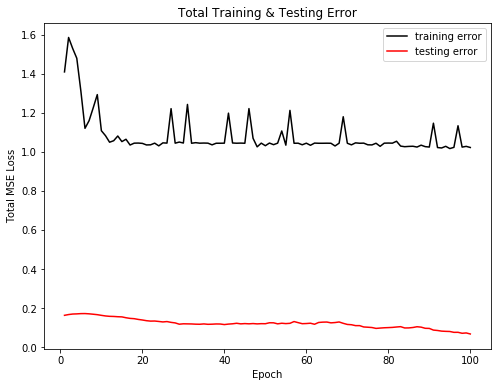

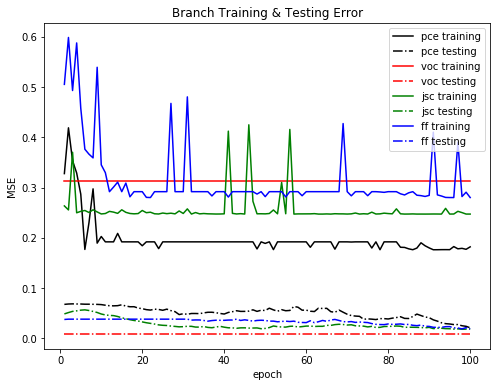

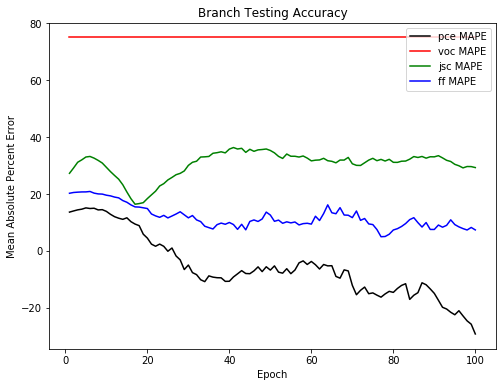

In [12]:
%autoreload
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OPV_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                     pce_train_epoch_losses, pce_test_epoch_losses,
                     voc_train_epoch_losses, voc_test_epoch_losses,
                     jsc_train_epoch_losses, jsc_test_epoch_losses,
                     ff_train_epoch_losses, ff_test_epoch_losses)

nuts.plot_OPV_df_accuracies(epochs, pce_test_epoch_accuracies, voc_test_epoch_accuracies, 
                           jsc_test_epoch_accuracies, ff_test_epoch_accuracies)

In [20]:
model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = model(inputs)


In [21]:
def denorm(val, mean, std):
    denormed = val*mean+std
    print(mean)
    print(std)
    print('\n')
    return denormed

# print (y_test_key)

for key, val in y_test_key.items():
    if key == 'PCE':
        pce_labels = denorm(pce_labels, val[0], val[1])
        PCE_out = denorm(PCE_out, val[0], val[1])
        
    elif key == 'VocL':
        voc_labels = denorm(voc_labels, val[0], val[1])
        Voc_out = denorm(Voc_out, val[0], val[1])
        
    elif key == 'Jsc':
        jsc_labels = denorm(jsc_labels, val[0], val[1])
        Jsc_out = denorm(Jsc_out, val[0], val[1])
        
    elif key == 'FF':
        ff_labels = denorm(ff_labels, val[0], val[1])
        FF_out = denorm(FF_out, val[0], val[1])
        
    else:
        print('wut')
        

2.4667628962322983
0.33136644211939587


2.4667628962322983
0.33136644211939587


0.570173286290579
0.020590691982505415


0.570173286290579
0.020590691982505415


6.85293588875025
0.13412315085849347


6.85293588875025
0.13412315085849347


63.04295516282214
7.5082173637727685


63.04295516282214
7.5082173637727685




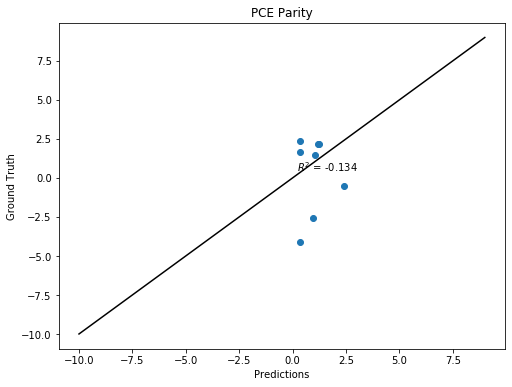

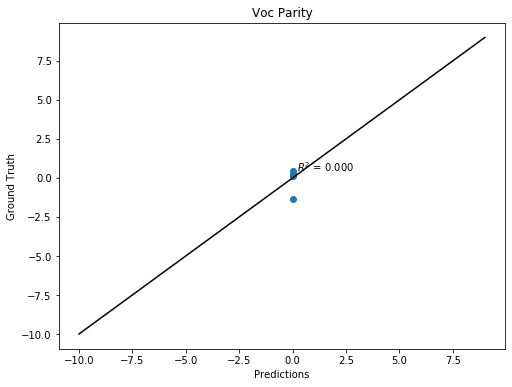

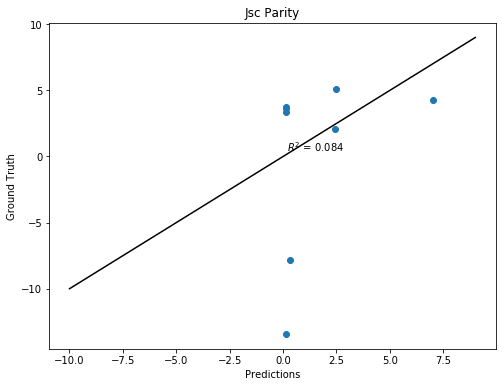

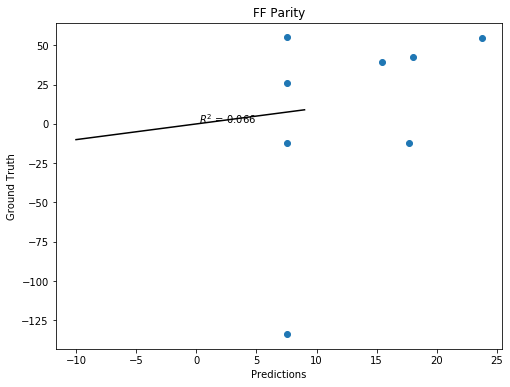

In [22]:
%autoreload

nuts.plot_OPV_parity(pce_labels, PCE_out, voc_labels, Voc_out, jsc_labels, Jsc_out, ff_labels, FF_out)